# 第04章：注意力机制演示

本notebook演示注意力机制的核心概念、Softmax函数的特性以及位置编码的作用。

In [4]:
# 基础库导入
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.colors import LinearSegmentedColormap

# 设置可视化样式
sns.set_style('whitegrid')
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文显示支持
plt.rcParams['axes.unicode_minus'] = False

## 1. Softmax函数演示

Softmax函数将任意实数向量转换为概率分布。下面可视化不同输入向量的Softmax输出：

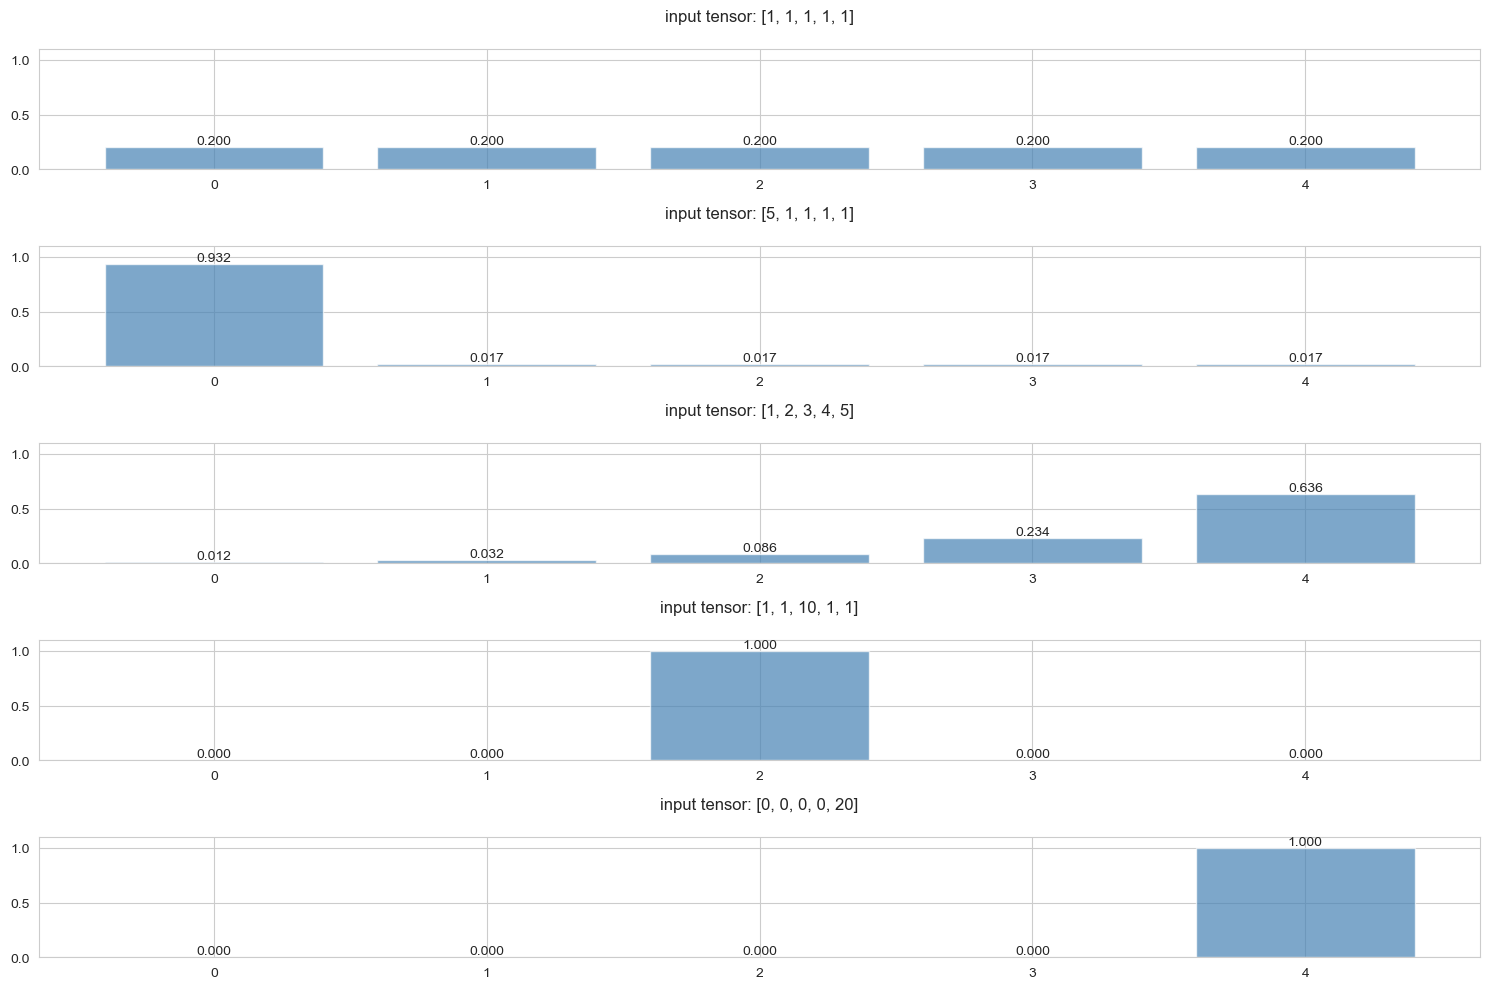

In [6]:
def softmax(x):
    """数值稳定版本的softmax"""
    x_max = np.max(x, axis=-1, keepdims=True)
    x = x - x_max  # 防止指数爆炸
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# 可视化不同输入模式
inputs = [
    [1, 1, 1, 1, 1],   # 均匀分布
    [5, 1, 1, 1, 1],   # 首元素主导
    [1, 2, 3, 4, 5],   # 线性增长
    [1, 1, 10, 1, 1],  # 中间突出
    [0, 0, 0, 0, 20]   # 末位极端
]

plt.figure(figsize=(15, 10))
for i, x in enumerate(inputs):
    plt.subplot(len(inputs), 1, i+1)
    probs = softmax(x)
    bars = plt.bar(range(len(x)), probs, alpha=0.7, color='steelblue')
    plt.title(f'input tensor: {x}', pad=20)
    plt.ylim(0, 1.1)
    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

### Softmax温度参数

温度系数控制输出分布的平滑程度，温度越低分布越尖锐：

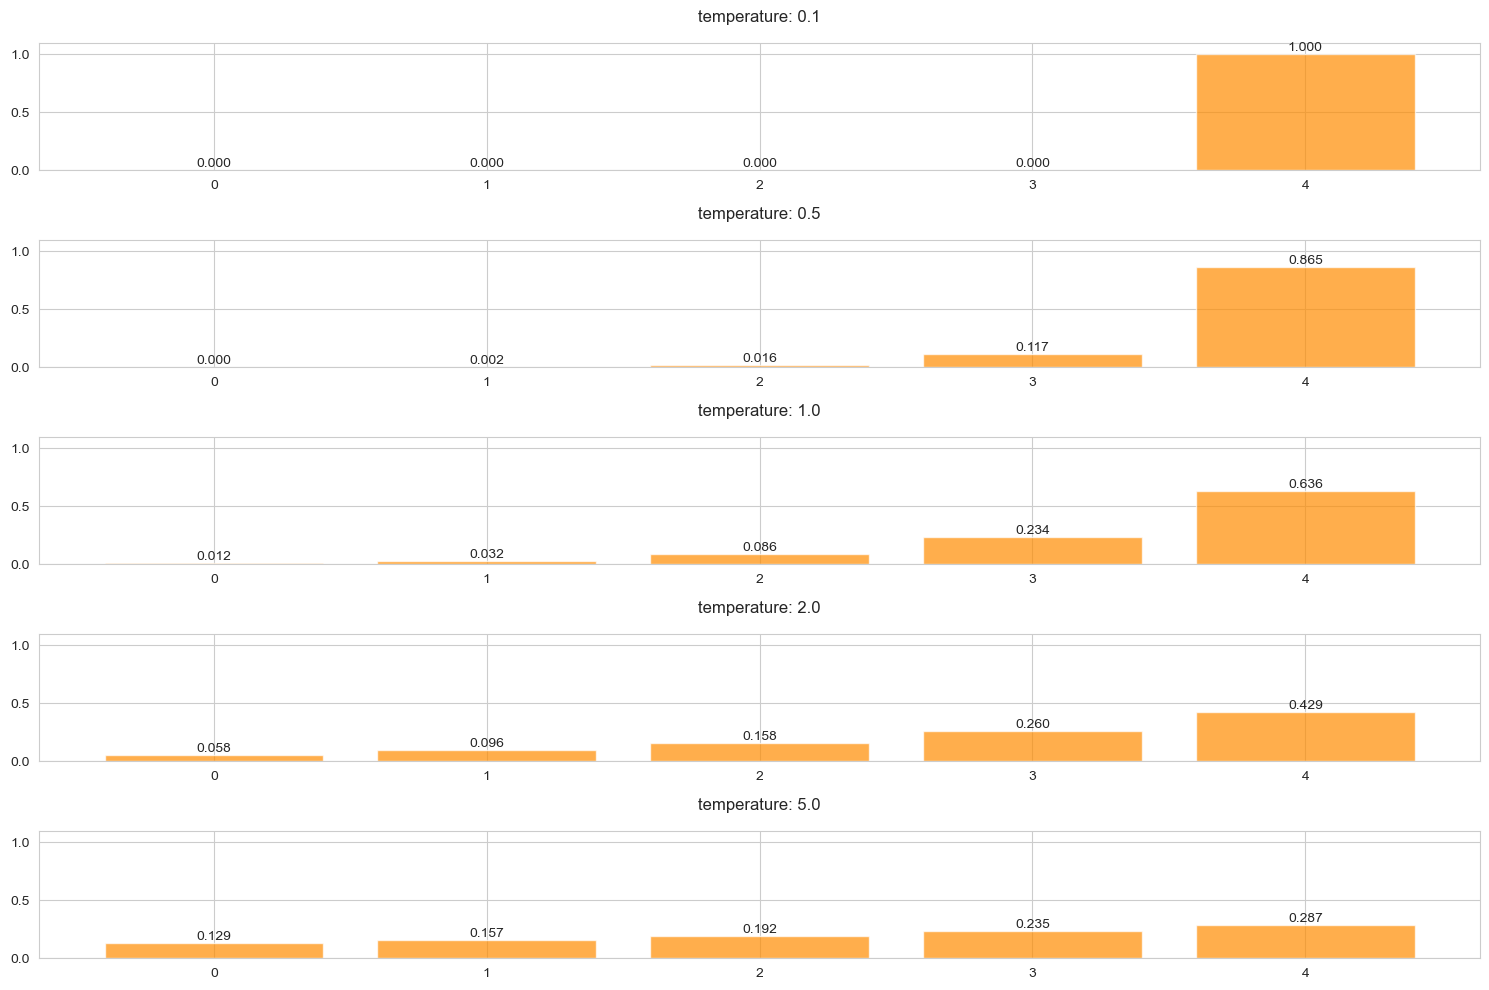

In [8]:
def softmax_with_temperature(x, temperature=1.0):
    """带温度参数的softmax"""
    x = np.array(x) / temperature  # 温度缩放
    return softmax(x)

# 温度对比实验
base_vector = [1, 2, 3, 4, 5]
temperatures = [0.1, 0.5, 1.0, 2.0, 5.0]

plt.figure(figsize=(15, 10))
for i, temp in enumerate(temperatures):
    plt.subplot(len(temperatures), 1, i+1)
    probs = softmax_with_temperature(base_vector, temp)
    bars = plt.bar(range(5), probs, alpha=0.7, color='darkorange')
    plt.title(f'temperature: {temp}', pad=15)
    plt.ylim(0, 1.1)
    # 添加数值标注
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom') 
plt.tight_layout()
plt.show()

## 2. 位置编码演示

Transformer使用正弦/余弦函数编码位置信息：

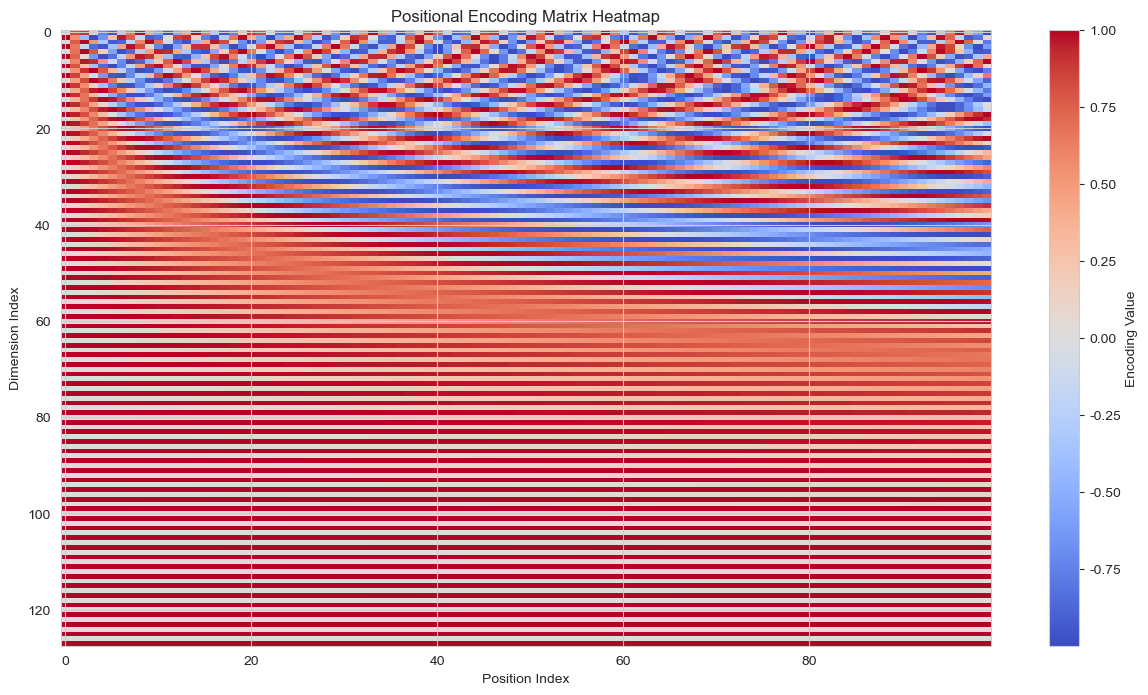

In [10]:
def positional_encoding(max_seq_len, d_model):
    """生成位置编码矩阵"""
    pe = np.zeros((max_seq_len, d_model))
    for pos in range(max_seq_len):
        for i in range(0, d_model, 2):
            pe[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
            if i+1 < d_model:
                pe[pos, i+1] = np.cos(pos / (10000 ** (i / d_model)))
    return pe

# 可视化编码矩阵
max_length = 100
d_model = 128
pe = positional_encoding(max_length, d_model)

plt.figure(figsize=(15, 8))
plt.imshow(pe.T, aspect='auto', cmap='coolwarm')
plt.xlabel('Position Index')           # 位置索引
plt.ylabel('Dimension Index')          # 维度索引
plt.colorbar(label='Encoding Value')   # 编码值
plt.title('Positional Encoding Matrix Heatmap')  # 位置编码矩阵热力图
plt.show()

## 3. 自注意力机制

实现缩放点积注意力并可视化权重矩阵：

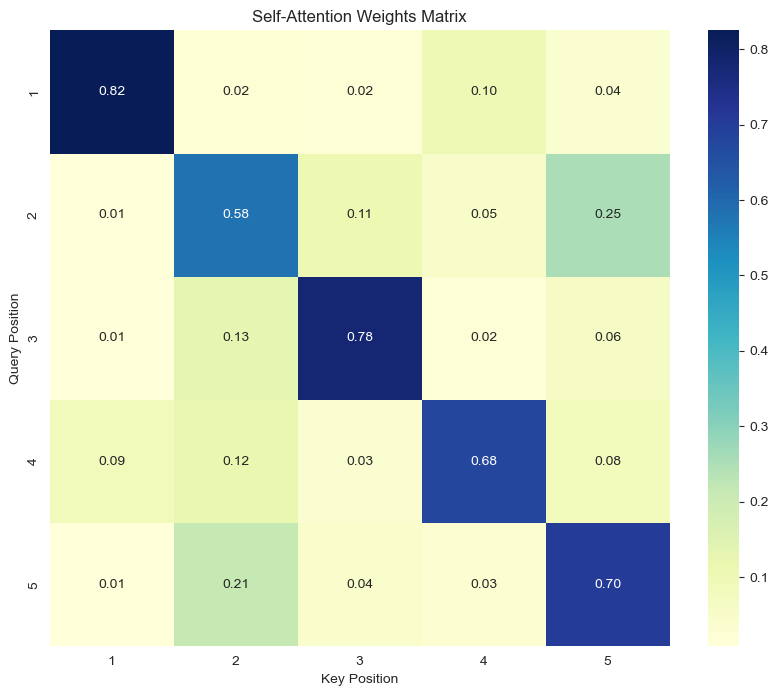

In [11]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """计算缩放点积注意力"""
    d_k = Q.shape[-1]
    scores = np.matmul(Q, K.transpose(0, 2, 1)) / np.sqrt(d_k)
    
    if mask is not None:
        scores = np.where(mask == 0, -1e9, scores)
    
    attn_weights = softmax(scores)
    output = np.matmul(attn_weights, V)
    return output, attn_weights

# 示例数据
np.random.seed(42)
batch_size = 1
seq_len = 5
d_model = 8
Q = np.random.randn(batch_size, seq_len, d_model)
K = V = Q  # 自注意力模式

# 计算并可视化
output, weights = scaled_dot_product_attention(Q, K, V)

plt.figure(figsize=(10, 8))
sns.heatmap(weights[0], annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=range(1, seq_len+1), 
            yticklabels=range(1, seq_len+1))

plt.title("Self-Attention Weights Matrix") # 自注意力权重矩阵
plt.xlabel("Key Position")                 # 键位置
plt.ylabel("Query Position")               # 查询位置
plt.show()

## 4. 注意力掩码演示

在自回归生成任务中，需要阻止模型访问未来位置信息：

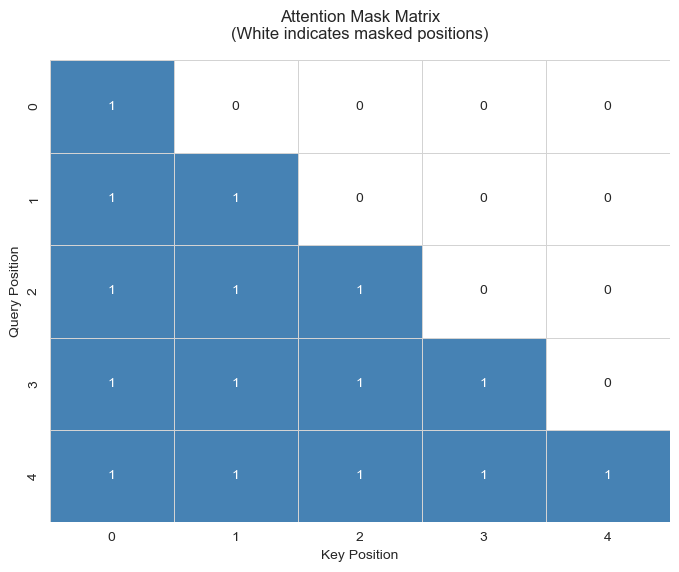

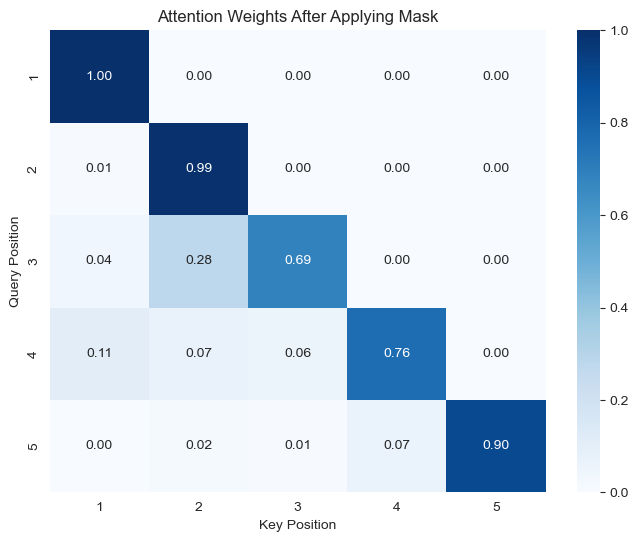

In [12]:
def visualize_attention_mask(seq_len=5):
    """创建并可视化上三角注意力掩码"""
    # 生成掩码矩阵（下三角为1，上三角为0）
    mask = np.triu(np.ones((1, seq_len, seq_len)), k=1) == 0
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(mask[0], 
                annot=True, 
                cmap=['white', 'steelblue'],
                cbar=False,
                linewidths=0.5,
                linecolor='lightgray')

    # 注意力掩码矩阵\n(白色表示被掩盖的位置)
    plt.title("Attention Mask Matrix\n(White indicates masked positions)", pad=15)
    plt.xlabel("Key Position")   # 键位置
    plt.ylabel("Query Position") # 查询位置
    plt.show()

    # 使用示例数据验证掩码效果
    np.random.seed(2023)
    demo_Q = np.random.randn(1, seq_len, 8)
    masked_output, masked_weights = scaled_dot_product_attention(
        demo_Q, demo_Q, demo_Q, mask=mask
    )
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(masked_weights[0], 
                annot=True, 
                fmt=".2f", 
                cmap="Blues",
                xticklabels=range(1, seq_len+1),
                yticklabels=range(1, seq_len+1))
    plt.title("Attention Weights After Applying Mask") # 应用掩码后的注意力权重
    plt.xlabel("Key Position")                         # 键位置
    plt.ylabel("Query Position")                       # 查询位置
    plt.show()

visualize_attention_mask()

## 5. 中文文本分类实战

实现基于自注意力的情感分类模型：

In [30]:
class PositionalEncoding(nn.Module):
    """可学习的位置编码模块
    
    参数：
        d_model: 特征维度
        max_len: 最大序列长度
        
    特性：
        - 使用正弦/余弦函数生成位置编码
        - 支持超过训练时最大长度的位置编码
        - 与输入embedding相加实现位置感知
    """
    def __init__(self, d_model, max_len=100):
        super().__init__()
        
        position = torch.arange(max_len).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2) * 
                           (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数位置
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数位置
        pe = pe.unsqueeze(0)  # 增加batch维度 [1, max_len, d_model]
        
        self.register_buffer('pe', pe)  # 注册为不可训练参数

    def forward(self, x):
        """添加位置编码到输入序列
        
        参数：
            x: 输入张量 [B, L, D]
        """
        return x + self.pe[:, :x.size(1)]  # 自动广播到batch维度

In [45]:
# ----------------------
# 数据准备模块
# ----------------------
class TextDataset(torch.utils.data.Dataset):
    """自定义文本数据集"""
    def __init__(self, texts, labels, vocab, max_len=10):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        tokens = self.texts[idx].split()
        # 转换为ID序列并进行填充/截断
        ids = [self.vocab.get(t, self.vocab["<UNK>"]) for t in tokens]
        if len(ids) < self.max_len:
            ids += [self.vocab["<PAD>"]] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]
        return {
            'input_ids': torch.LongTensor(ids),
            'label': torch.LongTensor([self.labels[idx]])
        }

# 实例化数据集
# texts = [
#     "我 喜欢 这部 电影",
#     "这部 电影 很 棒",
#     "这部 电影 很 无聊",
#     "我 讨厌 这部 电影",
#     "这 是 有史以来 最 糟糕 的 电影"
# ]
# labels = [1, 1, 0, 0, 0]
# vocab = {"<PAD>": 0, "<UNK>": 1}
# for text in texts:
#     for token in text.split():
#         if token not in vocab:
#             vocab[token] = len(vocab)

# dataset = TextDataset(texts, labels, vocab)
# print(f"词汇表样例：{ {k:v for k,v in list(vocab.items())[:5]}}")

# Instantiate dataset
texts = [
    "I love this movie",
    "This movie is great",
    "This movie is boring",
    "I hate this movie",
    "This is the worst movie ever"
]
labels = [1, 1, 0, 0, 0]  # 保持相同的标签结构（1=正面，0=负面）
vocab = {"<PAD>": 0, "<UNK>": 1}

# 构建词汇表
for text in texts:
    for token in text.split():  # 现在处理的是英文单词
        if token not in vocab:
            vocab[token] = len(vocab)

dataset = TextDataset(texts, labels, vocab)
print(f"Sample vocabulary: { {k:v for k,v in list(vocab.items())[:5]}}")

Sample vocabulary: {'<PAD>': 0, '<UNK>': 1, 'I': 2, 'love': 3, 'this': 4}


In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=32, num_heads=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        # 关键修复：设置 batch_first=True
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            batch_first=True  # 明确使用 batch_first 格式
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        self.classifier = nn.Linear(d_model, 2)

    def forward(self, x, mask=None):
        padding_mask = (x == 0)  # 自动生成形状为 [B, L] 的mask
        
        x = self.embedding(x)  # [B, L] -> [B, L, D]
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x, src_key_padding_mask=padding_mask)
        x = x.mean(dim=1)  # 平均池化
        return self.classifier(x)

In [46]:
class SelfAttention(nn.Module):
    """实现缩放点积自注意力机制
    
    参数：
        d_model: 输入特征维度
        
    特性：
        - 支持注意力掩码
        - 自动处理不同序列长度
        - 返回注意力权重供可视化分析
    """
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.query = nn.Linear(d_model, d_model)  # 查询变换
        self.key = nn.Linear(d_model, d_model)    # 键变换
        self.value = nn.Linear(d_model, d_model)  # 值变换
        
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        
        # 生成Q/K/V矩阵
        Q = self.query(x)  # [B, L, D]
        K = self.key(x)    # [B, L, D]
        V = self.value(x)  # [B, L, D]
        
        # 计算注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model)
        
        # 应用注意力掩码
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
            
        # 计算注意力权重
        attn_weights = F.softmax(scores, dim=-1)
        
        # 上下文向量计算
        context = torch.matmul(attn_weights, V)
        
        return context, attn_weights

### 位置编码器
实现Transformer风格的正弦位置编码：

In [47]:
# ----------------------
# 数据准备模块 (保持不变)
# ----------------------
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, vocab, max_len=10):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        tokens = self.texts[idx].split()
        ids = [self.vocab.get(t, self.vocab["<UNK>"]) for t in tokens]
        if len(ids) < self.max_len:
            ids += [self.vocab["<PAD>"]] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]
        return {
            'input_ids': torch.LongTensor(ids),
            'label': torch.LongTensor([self.labels[idx]])  # 保持维度 [1]
        }

# ----------------------
# 修正后的训练函数
# ----------------------
def train_model(dataset, num_epochs=200):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)
    model = TransformerClassifier(len(vocab))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch in dataloader:
            inputs = batch['input_ids']
            labels = batch['label'].view(-1)  # 关键修复：调整维度为 [B]
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch+1) % 50 == 0:
            avg_loss = total_loss / len(dataloader)
            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")
    
    return model

# 执行训练
trained_model = train_model(dataset)

Epoch 50/200 | Loss: 0.0037
Epoch 100/200 | Loss: 0.0009
Epoch 150/200 | Loss: 0.0005
Epoch 200/200 | Loss: 0.0003


In [38]:
# ----------------------
# 训练验证模块
# ----------------------
def train_model(dataset, num_epochs=200):
    """模型训练流程"""
    # 数据加载器
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)
    
    # 模型初始化
    model = TransformerClassifier(len(vocab))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    # 训练循环
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch in dataloader:
            inputs = batch['input_ids']
            labels = batch['label'].squeeze()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # 每50轮打印进度
        if (epoch+1) % 50 == 0:
            avg_loss = total_loss / len(dataloader)
            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")
    
    return model


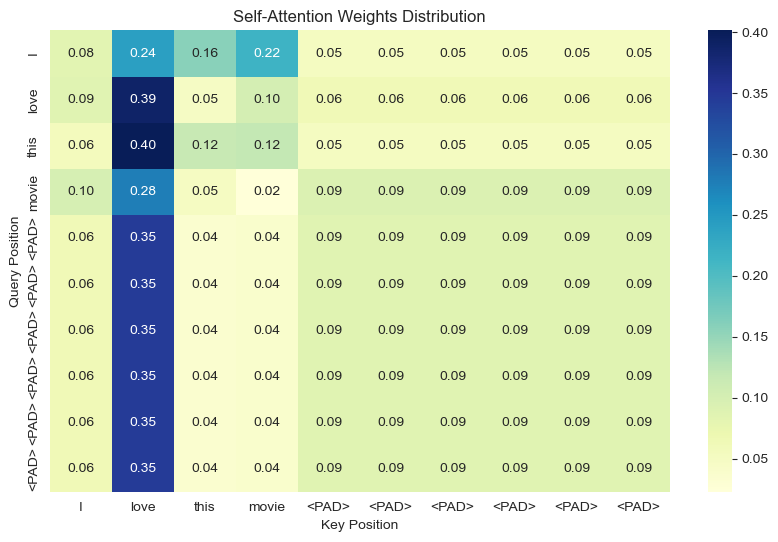

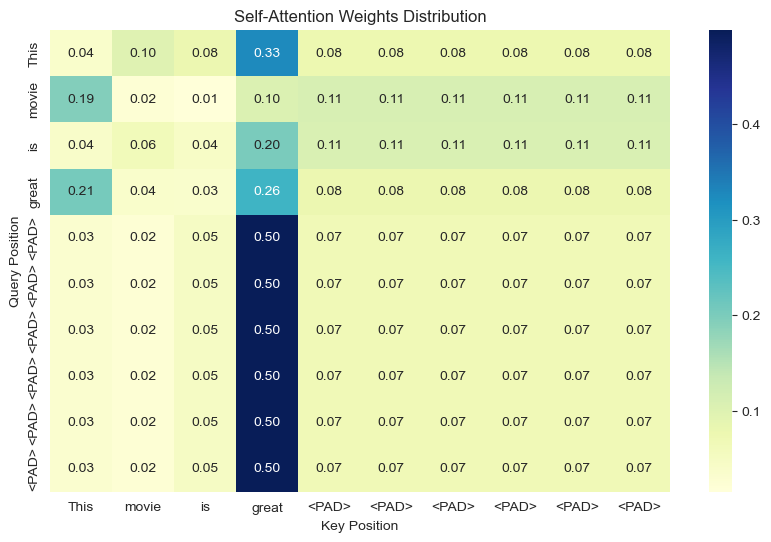

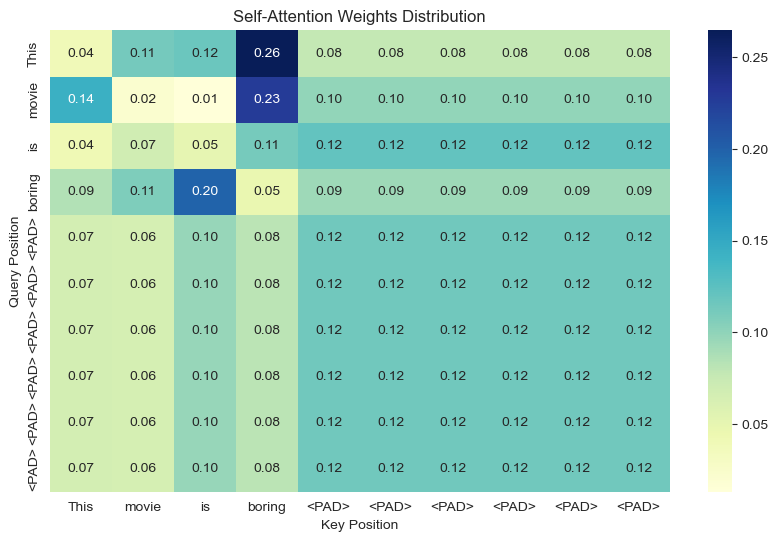

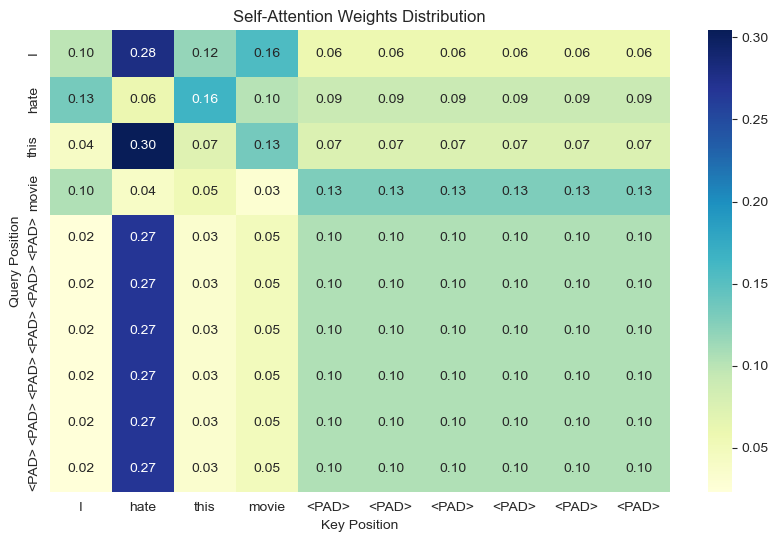

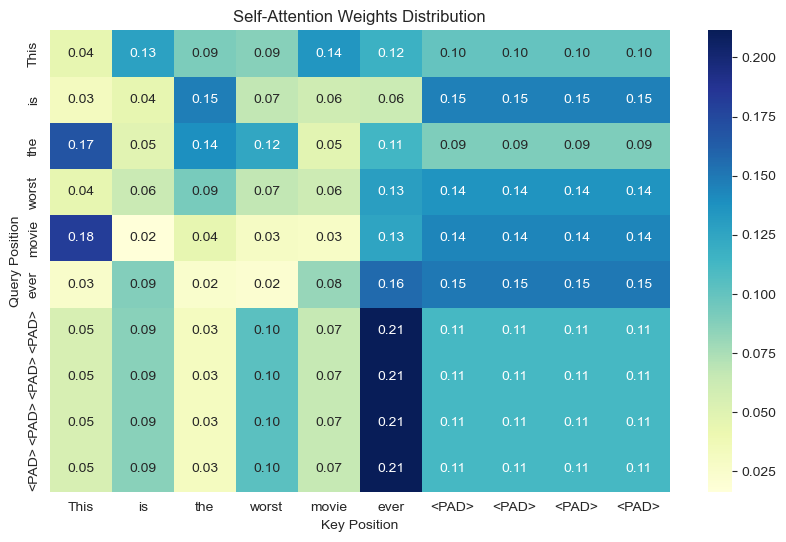

In [48]:
# ----------------------
# 注意力可视化模块
# ----------------------
def visualize_attention(model, dataset, vocab):
    """可视化模型注意力模式"""
    model.eval()
    id_to_word = {v:k for k,v in vocab.items()}
    
    with torch.no_grad():
        for sample in dataset:
            input_ids = sample['input_ids'].unsqueeze(0)
            # 提取第一个transformer层的注意力权重
            attn_weights = model.transformer_encoder.layers[0].self_attn(
                model.embedding(input_ids), 
                model.embedding(input_ids),
                model.embedding(input_ids)
            )[1]
            
            # 转换为numpy数组
            attn = attn_weights[0].numpy()
            tokens = [id_to_word.get(i.item(), '<UNK>') for i in input_ids[0]]
            
            # 绘制热力图
            plt.figure(figsize=(10, 6))
            sns.heatmap(attn, 
                        annot=True, 
                        fmt=".2f", 
                        cmap="YlGnBu",
                        xticklabels=tokens,
                        yticklabels=tokens)
            plt.title("Self-Attention Weights Distribution")
            plt.xlabel("Key Position")
            plt.ylabel("Query Position")
            plt.show()

visualize_attention(trained_model, dataset, vocab)